# Introduction 
In this notebook, we present an experimental design pipeline to find the most informative experiment that can resolve a parameter non-identification issue in a dynamical system. For illustration purposes, we choose a dynamical system that corresponds to a toy model of fish schooling, wherein two fish deterministically match each other's swimming directions with different copy coefficients or rates. The scientific question/task is to determine their individual copying coefficients from observed polarization data. 

In particular, we use Chiro's dynamical systems module to model the system, and its model transformation tools to easily express and simulate different experimental contexts. 

First, let's load all the required modules into the notebook.

In [15]:
from chirho_diffeqpy import DiffEqPy
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
import numpy as np
from pyro import sample
from typing import Tuple
import matplotlib.pyplot as plt
import pyro.distributions as dist
from contextlib import ExitStack, nullcontext
from pyro.contrib.autoname import scope
from functools import partial
import pyro
import torch
from chirho.observational.handlers import condition
from itertools import product
from toy_fish.handlers import VirtualFishContext
from toy_fish.ops import cos, NoVirtualFish, virtual_fish_dynamics
from collections import namedtuple
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy

pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(82901)

# System Definition

Many species of fish are known to exhibit a social phenomenon known as schooling, wherein a group of individuals come together and swim in the same direction in a co-ordinated manner.  Let's consider a simple dynamical model of this phenomenon with two fish whose heading directions are denoted by the angles $\theta_1(t)$ and $\theta_2(t)$ respectively. For simplicity, we ignore spatial co-ordinates, and only describe the dynamics of their heading angles. Suppose the fish match each other’s heading angles deterministically, with potentially different copying rates $\alpha$ and $\beta$. 

The dynamics can be described by the following system of ODEs :

$$\frac{d\theta_1}{dt} = \alpha(\theta_2-\theta_1)$$
$$\frac{d\theta_2}{dt} = \beta(\theta_1-\theta_2)$$

Under these dynamics, the heading angles of the two fish approach a common value exponentially fast. 

Let's set up the dynamical system and plot a sample trajectory.

### General, Multi-Fish System Dynamics

In [16]:
def pure_schooling_dynamics(state, atemp_params):
    thetas = state['thetas']
    # Later on in the notebook, we will introduce the idea of a "virtual" fish
    # that can be used as an experimental perturbation to the system.
    # For now, let's set up the dynamical system, keeping this perturbation in mind.
    
    # The presence/absence of a virtual fish is denoted by the experimental context.
    # The following block computes the effect of the virtual fish on the dynamics,
    # if the model is being run in the experimental context of a virtual fish
    try:
        # ...if the virtual fish is present.
        ddt_vfish = virtual_fish_dynamics(state, atemp_params)
        vfish_theta = state['vfish_theta']
        virtual_fish_diff = vfish_theta - thetas
    except NoVirtualFish:
        # ...otherwise proceed with no virtual fish.
        ddt_vfish = dict()
        virtual_fish_diff = 0.0
    
    # Compute the difference in heading angles between the real fish and virtual fish.
    thetas_diff_mat = thetas[..., :, None] - thetas[..., None, :]
    thetas_diff_tots = thetas_diff_mat.sum(axis=-2) + virtual_fish_diff
    assert thetas.shape == thetas_diff_tots.shape
    
    # And the resulting dynamics.
    copy_coefs = atemp_params['copy_coefs']
    dthetas = thetas_diff_tots * copy_coefs
    
    return dict(
        thetas=dthetas,
        **ddt_vfish
    )

### Low Level Experimental Model

In [17]:
START_T = torch.tensor(0.0)
END_T = torch.tensor(10.0)
RES = 50
GET_TRUE_COPY_COEFS = lambda: torch.tensor([3., 1.])

def run_experiment(logging_times, initial_state, atemp_params):
    with LogTrajectory(times=logging_times) as logging_trajectory:
        simulate(
            pure_schooling_dynamics,
            initial_state,
            START_T,
            END_T,
            atemp_params=atemp_params
        )
    return logging_trajectory.trajectory

### Visualization

In [72]:
def plot_experiments(trajectories : dict, polarizations : dict, polarization_linestyles=None):
    if len(trajectories):
        fig,ax = plt.subplots(1,len(trajectories),figsize=(4*len(trajectories),4))
        for i, label in enumerate(trajectories.keys()):
            trajectory = trajectories[label]
            plotlabels = [f"fish {i}" for i in range(1,1+trajectory['thetas'].shape[0])]
            ax[i].plot(trajectory['thetas'].detach().numpy().T, label=plotlabels)
            if 'vfish_theta' in trajectory:
                ax[i].plot(trajectory['vfish_theta'].detach().numpy(), label='virtual fish', linestyle="--")
            ax[i].legend()
            ax[i].set_xlabel("Time",fontsize=15)
            ax[i].set_ylabel(r"$\theta_i(t)$",fontsize=15)
            ax[i].set_title(label,fontsize=15)
        fig.suptitle("Trajectories",fontsize=20)
        fig.tight_layout()
        plt.show()

    if len(polarizations):
        if polarization_linestyles is None:
            polarization_linestyles = ['-'] * len(polarizations)
        plt.figure()
        plt.suptitle("Polarizations",fontsize=20)
        for i, (label, linestyle) in enumerate(zip(polarizations.keys(), polarization_linestyles)):
            polarization = polarizations[label]
            plt.plot(polarization.detach().numpy(), label=label, linestyle=linestyle)
        plt.xlabel("Time",fontsize=15)
        plt.ylabel("Polarization",fontsize=15)

        plt.legend()
        plt.show()

### Sample trajectory with two fish

In [19]:
SOLVER = DiffEqPy()

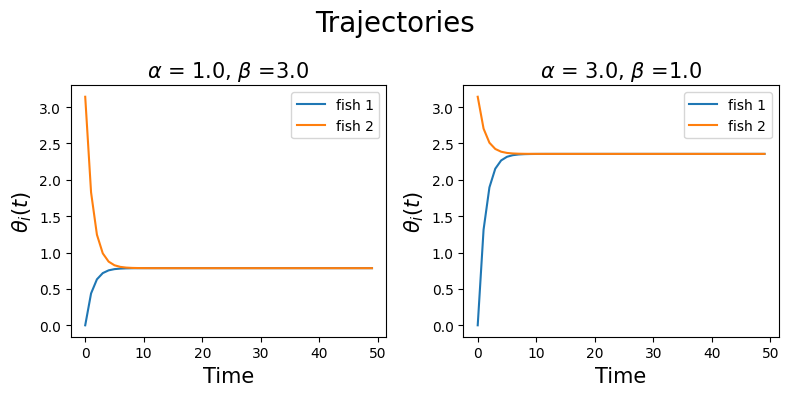

In [20]:
# Default experimental context with no virtual fish
no_vfish = nullcontext()

fixed_observation_times = torch.linspace(START_T, END_T, RES)
initial_state = torch.tensor([0, torch.pi])
copy_coefs13 = torch.tensor([1., 3.])
copy_coefs31 = torch.tensor([3., 1.])

with SOLVER, no_vfish:
    traj13 = run_experiment(
        logging_times=fixed_observation_times,
        initial_state=dict(thetas=initial_state),
        atemp_params=dict(
            copy_coefs= copy_coefs13
        )
    )

    traj31 = run_experiment(
        logging_times=fixed_observation_times,
        initial_state=dict(thetas=initial_state),
        atemp_params=dict(
            copy_coefs=copy_coefs31
        )
    )

trajectories= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : traj13,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : traj31
}

plot_experiments(trajectories=trajectories, polarizations={})

# Macroscopic Observations

We can quantify the extent of alignment in the swimming directions of the fish using the mean of their heading direction vectors.

$$\vec{m} = \frac{1}{2}\begin{bmatrix} \mathrm{cos}\theta_1 + \mathrm{cos}\theta_2 \\ \mathrm{sin}\theta_1 + \mathrm{sin}\theta_2 \\\end{bmatrix}$$ 

In particular, we might be interested in the macroscopic order parameter, polarization, defined as the magnitude $|\vec{m}|$. Polarization takes values in [0,1], with $|\vec{m}|=1$ denoting perfect alignment, and $|\vec{m}|=0$ denoting perfect misalignment in swimming directions. We have,

$$
|\vec{m}| = \sqrt{\frac{1+\mathrm{cos}\Delta\theta}{2}}, \quad \Delta\theta = \theta_1- \theta_2
$$

Now, $$\frac{d\Delta\theta}{dt} = -(\alpha + \beta) \Delta \theta$$

which implies, 
$$\Delta \theta = \Delta\theta_0 \mathrm{e}^{-(\alpha+\beta)t}$$

and, $$|\vec{m}(t)| = \sqrt{\frac{1+\mathrm{cos}\left(\Delta\theta_0 \mathrm{e}^{-(\alpha+\beta)t}\right)}{2}}$$

Thus, we see that for the chosen toy model, the dynamics of the polarization only depend on the sum of the copy coeffients of the two fish ($\alpha + \beta$).

In [21]:
def polarization_fn(theta):
    theta = theta.T
    assert theta.shape[-1] == 2, "Multi-fish polarization is not yet implemented!"
    return torch.sqrt((1 + torch.cos(theta[...,0] - theta[...,1]))/2)

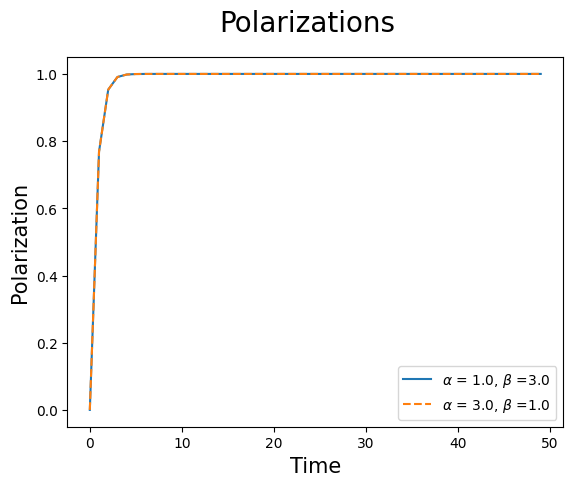

In [73]:
polarizations = {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : polarization_fn(traj13['thetas']),
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : polarization_fn(traj31['thetas'])
}

plot_experiments(trajectories={}, polarizations=polarizations, polarization_linestyles=['-', '--'])

Let's imagine a scenario where we are interested in individual heterogeneity of copying parameters, but can only make macroscopic measurements of the system. In other words, we only have access to the polarization, and not the individual heading angle trajectories. The analytical solution for $|\vec{m}|$ shows that any parameter inference using the macroscopic data would be unable to recover the individual copy coefficients ($\alpha$ and $\beta$). This is an example of a parameter non-identification issue.

Let's illustrate this parameter non-identification by running inference conditioned on the macroscopic data.


**Note**: for this toy example with two fish, restricting experimental data to macroscopic observations is perhaps an unrealistic constraint, given that it should be possible to track individuals in the tank, in a lab environment. However, there is some basis for this assumption when we consider observations of a large number of fish in more naturalistic settings. In this case, tracking individuals in video recordings using computer vision techniques may be noisy and unfeasible. However, it would still be possible to extract macroscopic quantities like polarization by analyzing visual flow in frames, for example. 

### Macroscopic Experimental Model

In [23]:
def copy_coefficient_prior(num_fish: int):
    return sample("copy_coefs", dist.Uniform(0., 10.).expand((num_fish,)).to_event(1))

def macroscopic_experiment_model(
    num_fish: int,
    macroscopic_noise: float,
    experimental_context = None,
    copy_coefs = None,
    initial_state = None,
):
    
    if experimental_context is None:
        experimental_context = nullcontext()
    
    if copy_coefs is None:
        copy_coefs = copy_coefficient_prior(num_fish)
    
    if initial_state is None:
        initial_state = dict(
            thetas=torch.linspace(0., torch.pi, num_fish)
        )
    
    fixed_observation_times = torch.linspace(START_T, END_T, RES)
    
    with SOLVER, experimental_context:
        trajectory = run_experiment(
            logging_times=fixed_observation_times,
            initial_state=initial_state,
            atemp_params=dict(
                copy_coefs=copy_coefs
            )
        )
        
        polarization = polarization_fn(trajectory['thetas'])
        # A trivial noise model over the polarization. This largely functions to relax the problem for inference.
        observed_polarization = pyro.sample("polarization", dist.Normal(polarization, macroscopic_noise).to_event(1))
        
        return trajectory, observed_polarization

In [24]:
LOW_NOISE = 0.0001

low_noise_experiment = partial(
    macroscopic_experiment_model,
    num_fish=2,
    macroscopic_noise=LOW_NOISE,
    experimental_context=no_vfish,
)
 
with pyro.condition(data={"copy_coefs": copy_coefs31}):
    traj31_noisy, pol31_noisy = low_noise_experiment()

with pyro.condition(data={"copy_coefs": copy_coefs13}):
    traj13_noisy, pol13_noisy = low_noise_experiment()

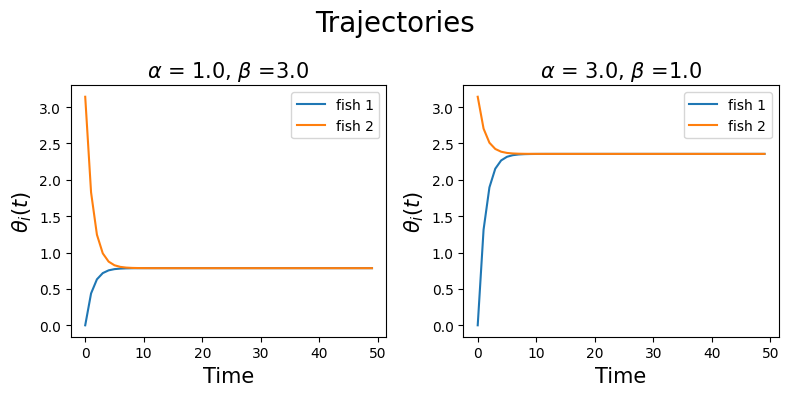

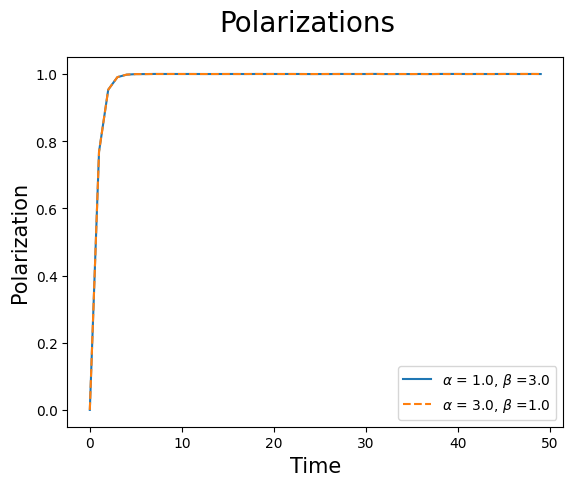

In [74]:
trajectories= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : traj13_noisy,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : traj31_noisy
}

polarizations= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : pol13_noisy,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : pol31_noisy
}

# confirm that noise does not significantly distort the dynamics!
plot_experiments(trajectories, polarizations, polarization_linestyles=['-', '--'])


To infer the true parameters, we evaluate the log likelihood of the polarization dyanmics over of a mesh of $\alpha$ and $\beta$ values. 

To estimate the posterior distribution, we then draw samples from the mesh, weighted by the computed log likelihoods.

In [26]:
PosteriorMesh = namedtuple("PosteriorMesh", ["alpha", "beta", "log_prob"])

def likelihood_mesh_2fish(model, n=90, lower=0., upper=7., verbose=True):
    # Make a torch meshgrid of copy coefficients.
    alpha = torch.linspace(lower, upper, n)
    beta = torch.linspace(lower, upper, n)
    alpha, beta = torch.meshgrid(alpha, beta, indexing='xy')
    latents = torch.stack([alpha, beta], dim=0).reshape(2, -1).T  # .shape == (n^2, 2)
    
    log_probs = []
    for copy_coefs in latents:
        with pyro.poutine.trace() as tr:
            with condition(data=dict(copy_coefs=copy_coefs)):
                model()
        log_probs.append(tr.trace.log_prob_sum())
        if verbose:
            print(f"Progress {len(log_probs)}/{latents.shape[0]}", end="\r")
    
    if verbose:
        print()
    
    return PosteriorMesh(alpha, beta, torch.tensor(log_probs).reshape(n, n))

In [27]:
def sample_from_mesh(mesh, num_samples, noise=0.05):
    xy = torch.stack([mesh.alpha, mesh.beta], dim=0).reshape(2, -1)
    probs = torch.softmax(mesh.log_prob.reshape(-1) - mesh.log_prob.max(), dim=0)
    idxs = torch.multinomial(probs, num_samples, replacement=True)
    return xy[:, idxs].T + torch.randn_like(xy[:, idxs].T) * noise

In [28]:
mesh31 = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol31_noisy}
    ),
    n=50
)

mesh13 = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol13_noisy}
    ),
    n=50
)

Progress 2500/2500
Progress 2500/2500


In [29]:
samples_31 = sample_from_mesh(mesh31, 1000, noise=0.08)
samples_13 = sample_from_mesh(mesh13, 1000, noise=0.08)

posteriors = {
    fr"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : {
        "samples" : samples_13,
        "true_params" : copy_coefs13
    },
    fr"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}" : {
        "samples" : samples_31,
        "true_params" : copy_coefs31
    }
}

In [30]:
XLIM = (0., 7.)
YLIM = (0., 7.)

def plot_samples(posteriors : dict):
    fig, ax = plt.subplots(1,len(posteriors),figsize=(4*len(posteriors),4))
    fig.suptitle("Posterior Samples",fontsize=20)

    for i, label in enumerate(posteriors.keys()):
        samples = posteriors[label]["samples"] 
        ax[i].scatter(samples[:, 0], samples[:, 1], s=0.2)
        ax[i].axvline(posteriors[label]["true_params"][0],linestyle="--", color='r')
        ax[i].axhline(posteriors[label]["true_params"][1],linestyle="--", color='r')
        ax[i].set_xlabel(fr"$\alpha$", fontsize=15)
        ax[i].set_ylabel(fr"$\beta$", fontsize=15)
        ax[i].set_title(label, fontsize=15)
        ax[i].set_xlim(*XLIM)
        ax[i].set_ylim(*YLIM)
    fig.tight_layout()

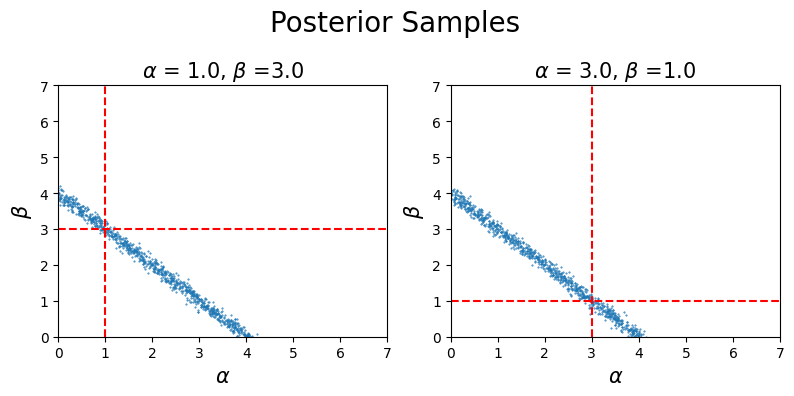

In [31]:
plot_samples(posteriors)

# Introducing a "virtual" fish in the experiment

Virtual reality (VR) paradigms that allow scientists to manipulate interactions between animals and their enviroments are a powerful tool for studying animal behavior.

 In the context of fish, some species that exhibit vision-based schooling behavior are known to respond to visual stimuli that resemble the shape and movement patterns of schooling fish [1]. 

Therefore, we consider here an experimental intervention with a "virtual" fish that elicits schooling behavior in the two real fish. 

For simplicity, let us assume that the virtual fish swims with a prescribed trajectory $\theta_{\mathrm{vf}}(t)$ [2]. 

We have,
$$\frac{d\theta_{\mathrm{vf}}}{dt} = f(t)$$
$$\frac{d\theta_1}{dt} = \alpha (\theta_2 - \theta_1) + \alpha (\theta_{\mathrm{vf}} - \theta_1), \quad
\frac{d\theta_2}{dt} = \beta (\theta_1 - \theta_2) + \beta (\theta_{\mathrm{vf}} - \theta_2) $$

We expect the presence of the virtual fish to alter the polarization dynamics of the system. Let us write down an analytical solution for the dynamics. 

We start by writing a general solution to homogenous system:

$$\frac{d\theta_1}{dt} = \alpha (\theta_2 - 2\theta_1) \quad
\frac{d\theta_2}{dt} = \beta (\theta_1 - 2\theta_2) $$

The general homogeneous solution is,
$$\theta_{1,2}^H(t) = \mathrm{e}^{-(\alpha+\beta)t}\left(A_{1,2}\, \mathrm{e}^{t\sqrt{\alpha^2+\beta^2-\alpha\beta}} + B_{1,2}\, \mathrm{e}^{-t\sqrt{\alpha^2+\beta^2-\alpha\beta}} \right)$$

where $A_{1,2}$ and $B_{1.2}$ are constants that depend on the initial conditions $\theta_{1,2}(0)$.

Suppose we choose a sinusoidal virtual fish stimulus, i.e. $\theta_{\mathrm{vf}}(t) = C \mathrm{sin}\left(\omega t \right)$. 

We can find a particular solution for the inhomogenous system by trying an *Ansatz*. 
$$\theta_{1,2}^P(t) = L_{1,2}\mathrm{sin}(\omega t) + K_{1,2}\mathrm{cos}(\omega t)$$

The constants $L_{1,2}$ and $K_{1,2}$ can be found by substituting $\theta_{1,2}^P(t)$ in the full system of ODEs and matching coefficients of cosine and sine terms. This can be formulated as solving a linear system of equations. Whether a solution exists depends on the choice of $ \alpha,\beta, \omega, C $. 

Finally, a full solution can be written as, 

$$\theta_{1,2}(t) =\theta_{1,2}^H(t) + \theta_{1,2}^P(t) $$

Which implies that,
$$\Delta\theta(t) = \mathrm{e}^{-(\alpha+\beta)t}\left(\Delta A \, \mathrm{e}^{t\sqrt{\alpha^2+\beta^2-\alpha\beta}} + \Delta B \, \mathrm{e}^{-t\sqrt{\alpha^2+\beta^2-\alpha\beta}} \right) + \Delta L \mathrm{sin}(\omega t) + \Delta K \mathrm{cos}(\omega t) $$

We see that there is non-trivial depends of $\Delta\theta$ (and thus, $|\vec{m}|$) on the individual copy parameters ($\alpha$, $\beta$) which may allow for the identification of the previous non-identified copy coefficients from macroscopic observations. We expect that the extent of identification would depend on the details of the experiment, namely, the initial conditions and virtual fish trajectory parameters. 

Let us see an example of this.

Notes :
1. Development of neural circuits for social motion perception in schooling fish. Zada, David et al. Current Biology, Volume 34, Issue 15, 3380 - 3391.e5
2. Note that this assumption is for illustration purposes only: the experimental design pipeline described here does not require a closed form description of the virtual trajectory -- for example, the trajectory of the virtual fish can be the output of a neural network that takes in the current polarization computes a response in real time, in a closed loop manner.


### Virtual Fish Experiments

In [32]:
def sinusoidal_virtual_fish(state, atemp_params):
    
    frequency = atemp_params['frequency']
    amplitude = atemp_params['amplitude']
    phase = atemp_params['phase']
    t = state['t']
    
    return dict(
        vfish_theta=amplitude * frequency * cos(frequency * t + phase)
    )

In [33]:
# Simple sinusoidal virtual fish.
exemplar_sinusoid_vfish = VirtualFishContext(
    sinusoidal_virtual_fish,
    initial_state=dict(
        vfish_theta=torch.tensor(0.0)
    ),
    atemp_params=dict(
        frequency=torch.tensor(1.),
        amplitude=torch.tensor(torch.pi),
        phase=torch.tensor(0.)
    )
)

In [34]:
low_noise_experiment = partial(
    macroscopic_experiment_model,
    num_fish=2,
    macroscopic_noise=LOW_NOISE,
    experimental_context=exemplar_sinusoid_vfish,
)

with pyro.condition(data={"copy_coefs": copy_coefs31}):
    traj31_w_vf, pol31_w_vf = low_noise_experiment()

with pyro.condition(data={"copy_coefs": copy_coefs13}):
    traj13_w_vf, pol13_w_vf = low_noise_experiment()

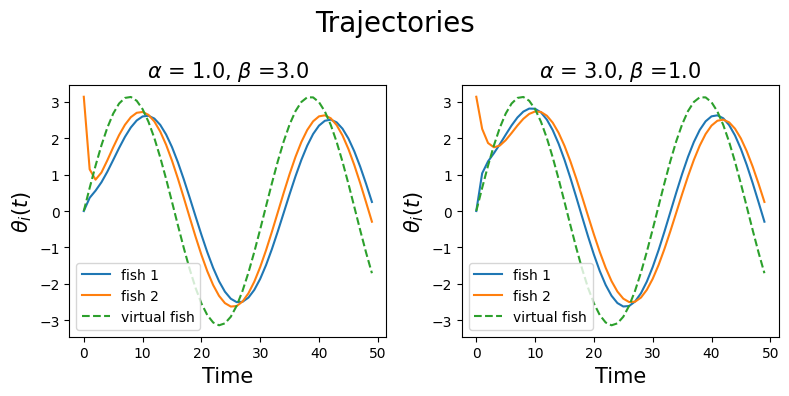

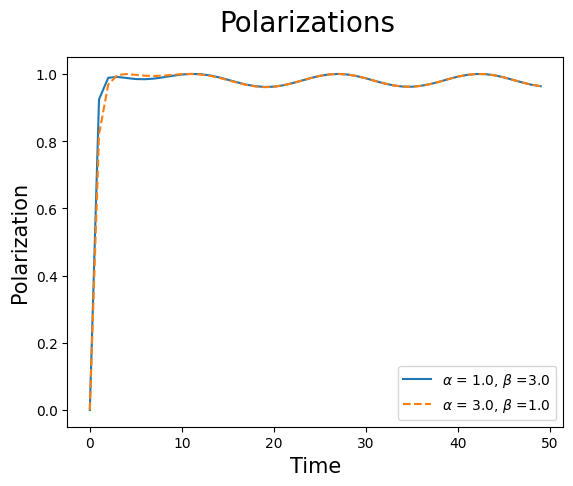

In [75]:
trajectories= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : traj13_w_vf,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : traj31_w_vf
}

polarizations= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : pol13_w_vf,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : pol31_w_vf
}

plot_experiments(trajectories,polarizations, polarization_linestyles=['-', '--'])


Progress 2500/2500
Progress 2500/2500


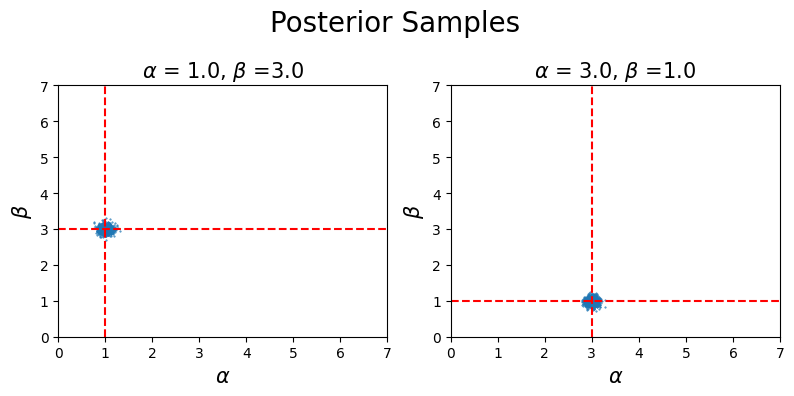

In [36]:
mesh31_w_vf = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol31_w_vf}
    ),
    n=50
)

mesh13_w_vf = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol13_w_vf}
    ),
    n=50
)

samples_31_w_vf = sample_from_mesh(mesh31_w_vf, 1000, noise=0.08)
samples_13_w_vf = sample_from_mesh(mesh13_w_vf, 1000, noise=0.08)

posteriors = {
    fr"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : {
        "samples" : samples_13_w_vf,
        "true_params" : copy_coefs13
    },
    fr"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}" : {
        "samples" : samples_31_w_vf,
        "true_params" : copy_coefs31
    }
}

plot_samples(posteriors)

##### Identified Copy Coefficients
Indeed, the virtual fish experiment can uniquely identify the unknown copy coefficients. Thus far, however, we've been operating in an unrealistic low-noise regime for illustration purposes. In practice, the fish interactions are not deterministic and the measurements are often noisy. We're using a deterministic ODE here, so we'll focus on adding noise to the measurements to capture this fuzziness. 

# Experimental Design

Virtual fish experiments can help identify otherwise non-identified parameters, but in practical noisy settings, some experiments are more *efficient* in recovering that information than others. To start, let's consider two virtual fish trajectories — one emulating a low frequency sinusoid starting aligned with one of the fish, and the other with a high frequency sinusoid starting "between" the two fish. We'll then explore how well they differentiate the copy coefficients of individual fish.

In [37]:
# <Virtual Fish Experiment A>
virtual_fish_A = VirtualFishContext(
    sinusoidal_virtual_fish,
    initial_state=dict(
        vfish_theta=torch.tensor(0.0)
    ),
    atemp_params=dict(
        frequency=torch.tensor(0.5),
        amplitude=torch.tensor(torch.pi),
        phase=torch.tensor(0.)
    )
)

vfish_experiment_A = partial(
    macroscopic_experiment_model,
    num_fish=2,
    macroscopic_noise=LOW_NOISE,
    experimental_context=virtual_fish_A,
)
# </Virtual Fish Experiment A>

# <Virtual Fish Experiment B>
virtual_fish_B = VirtualFishContext(
    sinusoidal_virtual_fish,
    initial_state=dict(
        vfish_theta=torch.tensor(torch.pi/2.)
    ),
    atemp_params=dict(
        frequency=torch.tensor(2.0),
        amplitude=torch.tensor(torch.pi),
        phase=torch.tensor(0.)
    )
)

vfish_experiment_B = partial(
    macroscopic_experiment_model,
    num_fish=2,
    macroscopic_noise=LOW_NOISE,
    experimental_context=virtual_fish_B,
)
# </Virtual Fish Experiment B>

In [38]:
def plot_single_trajectory(ax, trajectory):
    ax.plot(trajectory['thetas'].detach().numpy().T)
    if 'vfish_theta' in trajectory:
        ax.plot(trajectory['vfish_theta'].detach().numpy(), label='vfish_theta', linestyle="--")

In [39]:
def simulate_and_plot_3113_experiment(experiment, legend=False):
    with pyro.condition(data={"copy_coefs": torch.tensor([3., 1.])}):
        traj31, pol31 = experiment()
    
    with pyro.condition(data={"copy_coefs": torch.tensor([1., 3.])}):
        traj13, pol13 = experiment()
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].set_title("Polarizations")
    axs[0].plot(pol31.detach().numpy(), label="[3,1]")
    axs[0].plot(pol13.detach().numpy(), label="[1,3]")
    
    axs[1].set_title("Trajectories [3,1]")
    plot_single_trajectory(axs[1], traj31)
    
    axs[2].set_title("Trajectories [1,3]")
    plot_single_trajectory(axs[2], traj13)
    
    if legend:
        axs[2].legend(["Fish 1", "Fish 2", "Virtual Fish"], loc='lower right')
    
    plt.tight_layout()

### A Good Experiment Can Differentiate Competing Hypotheses
Without the virtual fish, the polarization data was identical for the competing copy coefficient hypotheses. With the virtual fish, we start to see some disambiguation. Different virtual fish trajectories, however, afford different degrees of differentiation. In this setting, it appears that the high frequency trajectory with a misaligned start induces a greater difference in the polarization data between the two hypotheses. This implies that it should be better at identifying the right one.

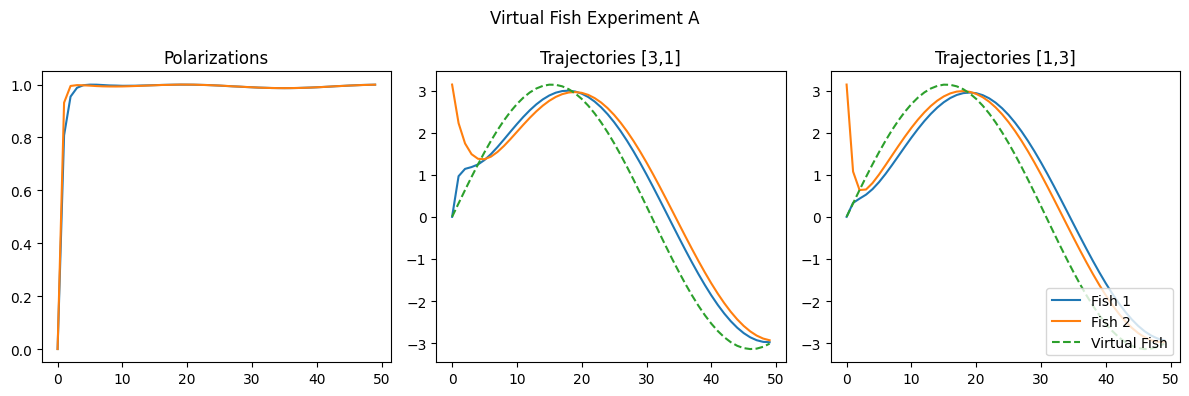

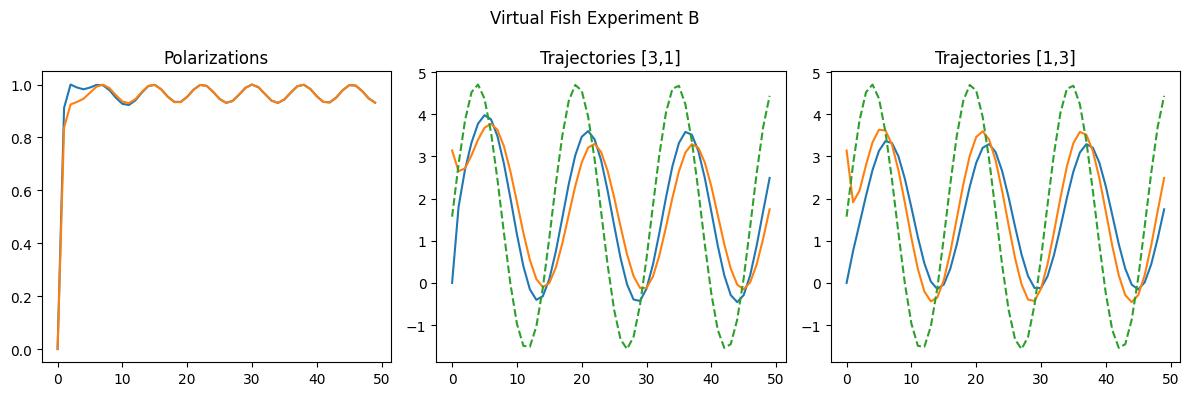

In [76]:
simulate_and_plot_3113_experiment(vfish_experiment_A, legend=True)
plt.suptitle("Virtual Fish Experiment A")
plt.tight_layout()
simulate_and_plot_3113_experiment(vfish_experiment_B)
plt.suptitle("Virtual Fish Experiment B")
plt.tight_layout()

### Noise in Observations
Higher differentiation becomes more important as our observations become more noisy. So far, we've assumed a low-noise regime that effectively rendered our scientific question a deterministic inverse problem — any differentiation over competing hypotheses was sufficient to identify the correct one. Practically, however, experiments involve noise that can dilute our conclusions. In this setting, it becomes clear that some experiments are better than others, even when the correct hypothesis is *technically* identifiable from experimental data.

Let's run experiments A and B again, but with higher observation noise. Note that, because we're using a deterministic system of ODEs, this noise is being added to the polarization data, but should still be sufficient to qualitatively capture the differences in experimental efficiency.  

In [41]:
HIGH_NOISE = 0.02

vfish_experiment_A_noise = partial(
    macroscopic_experiment_model,
    num_fish=2,
    macroscopic_noise=HIGH_NOISE,
    experimental_context=virtual_fish_A,
)

vfish_experiment_B_noise = partial(
    macroscopic_experiment_model,
    num_fish=2,
    macroscopic_noise=HIGH_NOISE,
    experimental_context=virtual_fish_B,
)

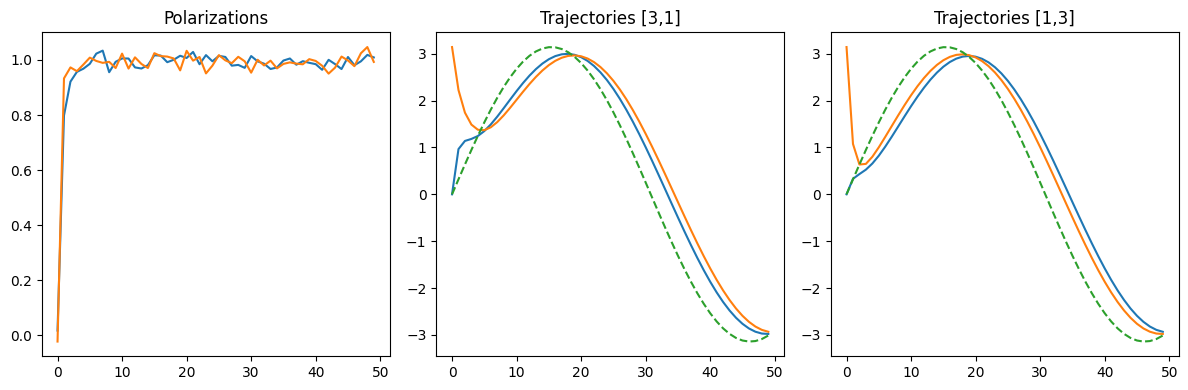

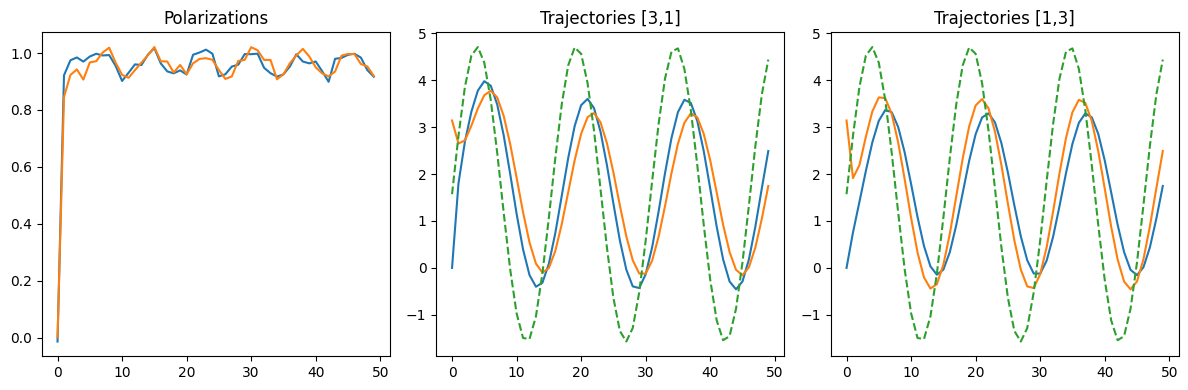

In [42]:
simulate_and_plot_3113_experiment(vfish_experiment_A_noise)
simulate_and_plot_3113_experiment(vfish_experiment_B_noise)

### Posterior Inference on Simulated Experimental Results
This noise profile, unsurprisingly, makes it more difficult to read off the experimental power of each virtual fish trajectory. We can, however, use the posterior inference machinery we've developed to explore the posterior distributions that would be induced over our competing hypotheses. Now, let's generate data from our two hypotheses and compare the posterior distributions over the latent copy coefficients.

In [43]:
# Generate data from the two hypotheses according to our model of experiment A.
with condition(data={"copy_coefs": torch.tensor([3., 1.])}):
    pol31_A_traj, pol31_A_noise = vfish_experiment_A_noise()

with condition(data={"copy_coefs": torch.tensor([1., 3.])}):
    _, pol13_A_noise = vfish_experiment_A_noise()

In [44]:
# Condition on the data, but not the hypothesis, and perform inference over the copy coefficients.
# <Inference on Data Simulated from Virtual Fish A>
with condition(data={"polarization": pol31_A_noise}):
    likelihood_mesh_31_A_noise = likelihood_mesh_2fish(
        vfish_experiment_A_noise,
        n=50,
    )

with condition(data={"polarization": pol13_A_noise}):
    likelihood_mesh_13_A_noise = likelihood_mesh_2fish(
        vfish_experiment_A_noise,
        n=50,
    )
# </Inference on Data Simulated from Virtual Fish A>

Progress 2500/2500
Progress 2500/2500


In [45]:
# Generate data from the two hypotheses according to our model of experiment B.
with condition(data={"copy_coefs": torch.tensor([3., 1.])}):
    _, pol31_B_noise = vfish_experiment_B_noise()
    
with condition(data={"copy_coefs": torch.tensor([1., 3.])}):
    _, pol13_B_noise = vfish_experiment_B_noise()

In [46]:
# <Inference on Data Simulated from Virtual Fish B>
with condition(data={"polarization": pol31_B_noise}):
    likelihood_mesh_31_B_noise = likelihood_mesh_2fish(
        vfish_experiment_B_noise,
        n=50,
    )
    
with condition(data={"polarization": pol13_B_noise}):
    likelihood_mesh_13_B_noise = likelihood_mesh_2fish(
        vfish_experiment_B_noise,
        n=50,
    )
# </Inference on Data Simulated from Virtual Fish B>

Progress 2500/2500
Progress 2500/2500


In [47]:
def plot_posterior(ax, mesh):
    samples = sample_from_mesh(mesh, 1000)
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=1.0)
    ax.set_xlim(XLIM)
    ax.set_ylim(YLIM)

    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$\beta$")


def plot_copy_coef_lines(ax, copy_coefs=None):
    if copy_coefs is None:
        copy_coefs = GET_TRUE_COPY_COEFS()
    
    ax.axvline(copy_coefs[0].item(), color='red', linestyle="--")
    ax.axhline(copy_coefs[1].item(), color='red', linestyle="--")
    
    
    
def plot_plot_3113_posteriors(mesh31, mesh13):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    plot_posterior(axs[0], mesh31)
    plot_copy_coef_lines(axs[0], copy_coefs=torch.tensor([3., 1.]))
    axs[0].set_title("Hypothesis [3,1]")
    
    plot_posterior(axs[1], mesh13)
    plot_copy_coef_lines(axs[1], copy_coefs=torch.tensor([1., 3.]))
    axs[1].set_title("Hypothesis [1,3]")

##### Visualizing Posteriors
We can now visualize our inferences as if we observed polarization data generated from each experiment under each copy coefficient hypothesis. We want to see how well our posteriors recover the generating hypothesis.

Text(0.5, 0.98, 'Posterior Inference for Virtual Fish A')

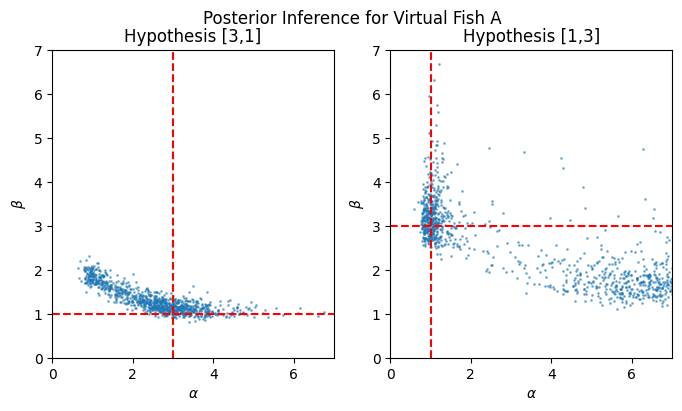

In [48]:
plot_plot_3113_posteriors(likelihood_mesh_31_A_noise, likelihood_mesh_13_A_noise)
plt.suptitle("Posterior Inference for Virtual Fish A")

Text(0.5, 0.98, 'Posterior Inference for Virtual Fish B')

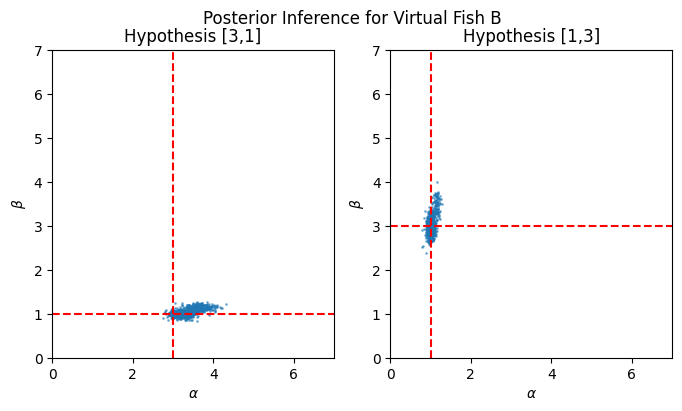

In [49]:
plot_plot_3113_posteriors(likelihood_mesh_31_B_noise, likelihood_mesh_13_B_noise)
plt.suptitle("Posterior Inference for Virtual Fish B")

### Expected Posterior Concentration as a Measure of Experimental Efficiency
We see from the above that, as expected, the high frequency trajectory with the misaligned start results in much tighter posterior conclusions! In other words, the results of that experiment point to a much smaller set of plausible copy coefficients. This is reflected as a higher concentration of samples around the hypothesis that generated the data. 

Thus far, however, we've glossed over something important — we don't know the copy coefficients to begin with, so how can we generate data from them to test our experiments? The answer is conceptually straightforward but computationally challenging: we want to measure the *expected* posterior concentration averaged over our competing hypotheses. Computationally, we can implement a nested Monte-Carlo approximation by 1) sampling from our space of competing hypotheses (e.g. our prior), and 2) run posterior inference and compute the posterior concentration. We can then average these concentration scores to get our expected concentration over the competing hypotheses.

To precisely quantify the posterior concentration, we'll use *entropy*, which is the expected log likelihood of the posterior. Denoting our posterior with $p(\alpha, \beta | \mathcal{D})$, the posterior entropy is defined as:

$$
H(\alpha, \beta \mid \mathcal{D}) = - \mathbb{E}_{p(\alpha, \beta | \mathcal{D})} \log p(\alpha, \beta | \mathcal{D})
$$

We assume our polarization data are distributed according to the following model, where the coefficients are sampled from the prior, and then pushed through the fish trajectory simulation model. Note that here, we're now using $\mathcal{D}$ as a random variable, and not a fixed dataset. Generally, this disambiguation should be clear from context.

$$
p(\mathcal{D}) = \mathbb{E}_{p(\alpha, \beta)}[p(\mathcal{D} | \alpha, \beta)]
$$

The expected entropy, then, is the entropy averaged over the possible datasets, which vary with the unknown copy coefficients and the noise in the observations.

$$
\mathbb{E}_{p(\mathcal{D})}\left[H(\alpha, \beta \mid \mathcal{D})\right]
$$

We can estimate this with nested Monte-Carlo by sampling coefficients from the prior, generating data, inferring the posterior from that data, and then computing its entropy. The final measure of a good experiment is the average entropy over posteriors induced by data generated from the space of competing hypotheses.

If we make Monte-Carlo samples as follows:
$$
\alpha_i, \beta_i \thicksim p(\alpha, \beta) \\
\mathcal{D}_i \thicksim p(\mathcal{D} | \alpha_i, \beta_i) \\
$$

We can then approximate the expected entropy as:
$$
\mathbb{E}_{p(\mathcal{D})}\left[H(\alpha, \beta \mid \mathcal{D})\right] \approx \frac{1}{N} \sum_{i=1}^N H(\alpha, \beta \mid \mathcal{D}_i)
$$

Noting finally that $H(\alpha, \beta \mid \mathcal{D})$ is fairly straightforward to estimate from our discrete approximation to our posterior (see the function below called `entropy_from_mesh`).


In [50]:
def entropy_from_mesh(mesh):
    # Normalize, in a numerically stable way, to get probabilities.
    probs = torch.softmax(mesh.log_prob.reshape(-1) - mesh.log_prob.max(), dim=0)
    # Compute entorpy.
    return -torch.sum(probs * torch.log(probs + 1e-10))

We can now compute the entropies of the four posteriors computed above, and note that virtual fish B results in much lower entropy, i.e. higher concentration of posterior conclusions. Importantly, this is not the *expected* entropy, but rather the entropy of the posterior consistent with our true parameters. In practice, we don't know those parameters, and so much average over competing hypotheses about those parameters.

In [51]:
print("Entropy of Posterior Inference for Virtual Fish A")
print(f"Hypothesis [3,1] A: {entropy_from_mesh(likelihood_mesh_31_A_noise).item():.2f}")
print(f"Hypothesis [1,3] A: {entropy_from_mesh(likelihood_mesh_13_A_noise).item():.2f}")
print()

print("Entropy of Posterior Inference for Virtual Fish B")
print(f"Hypothesis [3,1] B: {entropy_from_mesh(likelihood_mesh_31_B_noise).item():.2f}")
print(f"Hypothesis [1,3] B: {entropy_from_mesh(likelihood_mesh_13_B_noise).item():.2f}")

Entropy of Posterior Inference for Virtual Fish A
Hypothesis [3,1] A: 4.48
Hypothesis [1,3] A: 5.67

Entropy of Posterior Inference for Virtual Fish B
Hypothesis [3,1] B: 2.13
Hypothesis [1,3] B: 1.78


##### Computing the Expected Entropy
Now, we'll write some code to compute the expected entropy over a distribution of competing hypotheses. For simplicity, we'll fix our prior to be uniform in the interval [1, 4] for each copy coefficient.

In [52]:
basic_experiment = partial(
    macroscopic_experiment_model,
    num_fish=2,
    macroscopic_noise=HIGH_NOISE,
)


def estimate_posterior_entropy(experiment, polarization_data, **inference_kwargs):
    with condition(data={"polarization": polarization_data}):
        likelihood_mesh = likelihood_mesh_2fish(
            experiment,
            **inference_kwargs
        )
    
    return entropy_from_mesh(likelihood_mesh)
    

def expected_entropy(
    experimental_context,
    outer_n=100,
    inner_n=50,
):
    entropies = []
    for i in range(outer_n):
        # Define experiment.
        experiment = partial(basic_experiment, experimental_context=experimental_context)
        
        # Sample hypothesis from prior.
        copy_coefs = dist.Uniform(1., 4.).sample((2,))
        
        # Simulate data.
        with condition(data={"copy_coefs": copy_coefs}):
            _, polarization_data = experiment()
        
        # Compute posterior entropy.
        entropies.append(estimate_posterior_entropy(
            experiment,
            polarization_data,
            lower=1.,
            upper=4.,
            n=inner_n,
            verbose=False
        ))
        
        print(f"Progress {i+1}/{outer_n}", end="\r")
        
    print()
        
    return torch.stack(entropies)

In [53]:
entropies_A = expected_entropy(virtual_fish_A, outer_n=30, inner_n=25)
entropies_B = expected_entropy(virtual_fish_B, outer_n=30, inner_n=25)

Progress 30/30
Progress 30/30


In [77]:
# Plot the entropies with error bars.
def plot_expected_entropy(*entropies, names=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    for i, entropy in enumerate(entropies):
        ax.errorbar(
            i, 
            entropy.mean().item(), 
            yerr=torch.std(entropy).item() / np.sqrt(entropy.shape[0]), fmt='o', label=f"Virtual Fish {i}")
        
    
    ax.set_xticks(range(len(entropies)))
    if names is not None:
        ax.set_xticklabels(names)
    
    ax.set_ylabel("Expected Posterior Entropy")
    ax.set_title("Expected Entropy of Posterior")
    
    ax.set_xlim(-.5, len(entropies) - .5)

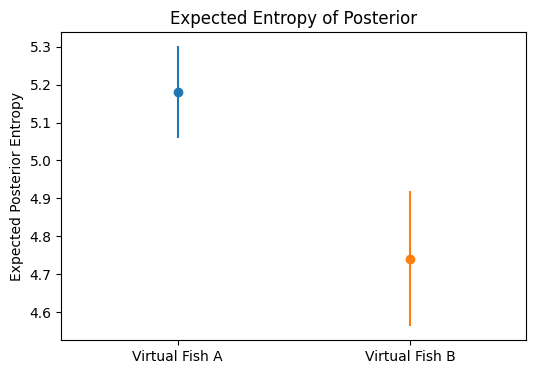

In [78]:
plot_expected_entropy(entropies_A, entropies_B, names=("Virtual Fish A", "Virtual Fish B"))

##### Virtual Fish B is a Better Experiment!
As expected, even when averaging over a set of possible copy coefficients, virtual fish B results in a lower expected posterior entropy. This means its conclusions are more concentrated, on average, than those resulting from the experiment with virtual fish A.  

### Searching Over the Space of Experiments
We now have a measure for the quality of our experiments, which means we can search over experimental parameters to find an efficient experiment! For now, we'll settle for a simple grid search over the starting position and frequency of the virtual fish trajectory. In practice, though, one could go so far as to define a virtual fish trajectory with a neural network, and then use gradient methods to optimize the trajectory for maximum experimental efficiency.

In [56]:
# For simplicity, leaving these with a single element.
grid_amplitude = [torch.tensor(torch.pi)]
grid_phase = [torch.tensor(0.)]
# But varying these over a grid.
grid_frequencies = [torch.tensor(v) for v in (0.5, 1.0, 2.0, 4.0)]
grid_vfish_theta0 = [torch.tensor(v) for v in (0., torch.pi/2)]

# Now create list of virtual fish trajectories
flat_grid_vfish_contexts = []
for amp, ph, frq, theta0 in product(grid_amplitude, grid_phase, grid_frequencies, grid_vfish_theta0):
    flat_grid_vfish_contexts.append(
        VirtualFishContext(
            sinusoidal_virtual_fish,
            initial_state=dict(
                vfish_theta=theta0
            ),
            atemp_params=dict(
                frequency=frq,
                amplitude=amp,
                phase=ph
            )
        )
    )

In [57]:
# Run the experiments and compute the expected entropies.
entropies = []
for i, vfish in enumerate(flat_grid_vfish_contexts):
    print(f"Running experiment {i+1}/{len(flat_grid_vfish_contexts)}")
    entropies.append(expected_entropy(vfish, outer_n=30, inner_n=25))

Running experiment 1/8
Progress 30/30
Running experiment 2/8
Progress 30/30
Running experiment 3/8
Progress 30/30
Running experiment 4/8
Progress 30/30
Running experiment 5/8
Progress 30/30
Running experiment 6/8
Progress 30/30
Running experiment 7/8
Progress 30/30
Running experiment 8/8
Progress 30/30


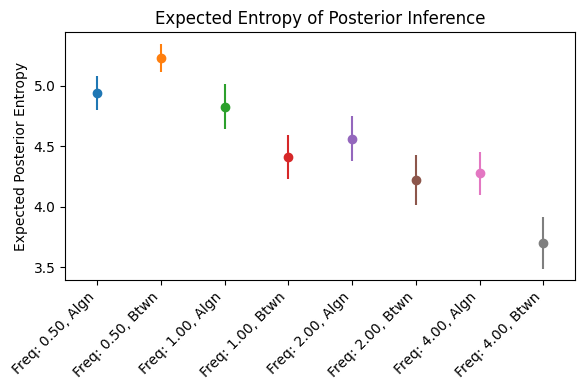

In [58]:
# Plot the expected entropies.
plot_expected_entropy(*entropies)
# Set the xticks to the grid parameters.
plt.xticks(range(len(flat_grid_vfish_contexts)), [
    f"Freq: {v.atemp_params['frequency'].item():.2f},"
    f" {'Algn' if torch.isclose(v.initial_state['vfish_theta'], torch.tensor(0.0)) else 'Btwn'}"
    for v in flat_grid_vfish_contexts], rotation=45, ha='right')
plt.tight_layout()
pass

##### Visualizing at True Coefficients
To visualize the trajectories and posteriors across the grid, we'll look just at what comes back for our unknown, true copy coefficients. In practice, of course, these aren't known, but this will give us a good sense of what our inferences would look like under the true copy coefficients and these experiments. We'll show the trajectories and the resultant posterior inferences in the grid, and print the estimated expected entropy that we computed for each experiment.

In [59]:
def simulate_experiment_and_inference(basic_experiment, *experimental_contexts, copy_coefs=None):
    
    if copy_coefs is None:
        copy_coefs = GET_TRUE_COPY_COEFS()
        
    trajectories, polarizations, posteriors = [], [], []
    
    for experimental_context in experimental_contexts:
        # Define the experiment.
        experiment = partial(basic_experiment, experimental_context=experimental_context)
        
        with condition(data={"copy_coefs": copy_coefs}):
            trajectory, polarization = experiment()
        
        trajectories.append(trajectory)
        polarizations.append(polarization)
        
        with condition(data={"polarization": polarization}):
            likelihood_mesh = likelihood_mesh_2fish(
                experiment,
                n=50,
            )
        
        posteriors.append(likelihood_mesh)
    
    return trajectories, polarizations, posteriors

In [103]:
pyro.set_rng_seed(892)
flat_grid_trajectories, flat_grid_polarizations, flat_grid_posteriors = simulate_experiment_and_inference(
    basic_experiment,
    *flat_grid_vfish_contexts,
    copy_coefs=GET_TRUE_COPY_COEFS()
)

Progress 2500/2500
Progress 2500/2500
Progress 2500/2500
Progress 2500/2500
Progress 2500/2500
Progress 2500/2500
Progress 2500/2500
Progress 2500/2500


In [104]:
# Reshape into a grid for plotting.
grid_trajectories = np.array(flat_grid_trajectories, dtype=object).reshape(len(grid_frequencies), len(grid_vfish_theta0))

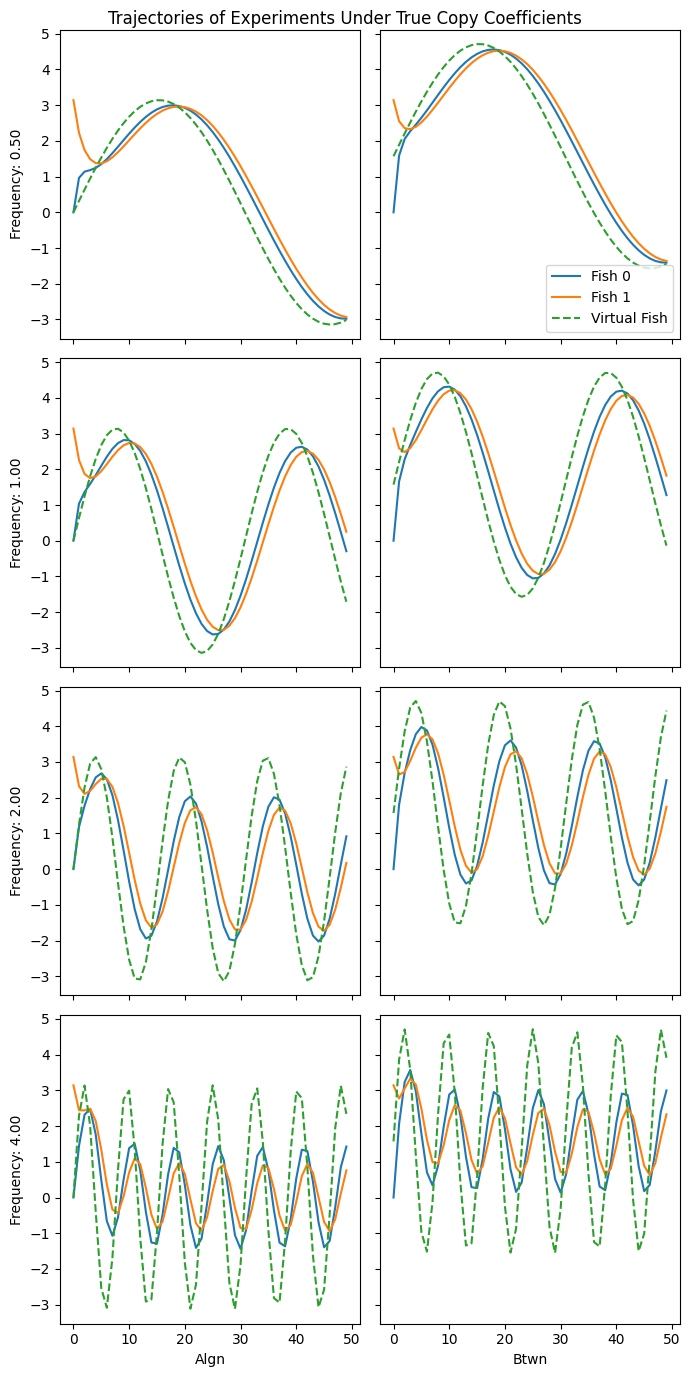

In [105]:
# And plot the grid of trajectories.
ni, nj = len(grid_frequencies), len(grid_vfish_theta0)
fig, axs = plt.subplots(ni, nj, figsize=(7, 14), sharex=True, sharey=True)
for i, j in product(range(ni), range(nj)):
    ax = axs[i][j]
    trajectory = grid_trajectories[i, j]
    plot_single_trajectory(ax, trajectory)

def label_axes(axs, grid_frequencies, grid_vfish_theta0):
    for i, j in product(range(ni), range(nj)):
        # Label the axes with the grid parameters. Use yaxis label for the leftmost column of plots,
        #  and an xaxis label for the bottom row.
        if j == 0:
            axs[i][j].set_ylabel(f"Frequency: {grid_frequencies[i].item():.2f}")
        if i == ni - 1:
            axs[i][j].set_xlabel(f"Algn" if torch.isclose(grid_vfish_theta0[j], torch.tensor(0.0)) else "Btwn")

label_axes(axs, grid_frequencies, grid_vfish_theta0)

axs[0][-1].legend(["Fish 0", "Fish 1", "Virtual Fish"], loc='lower right')

plt.suptitle("Trajectories of Experiments Under True Copy Coefficients")
plt.tight_layout()
pass

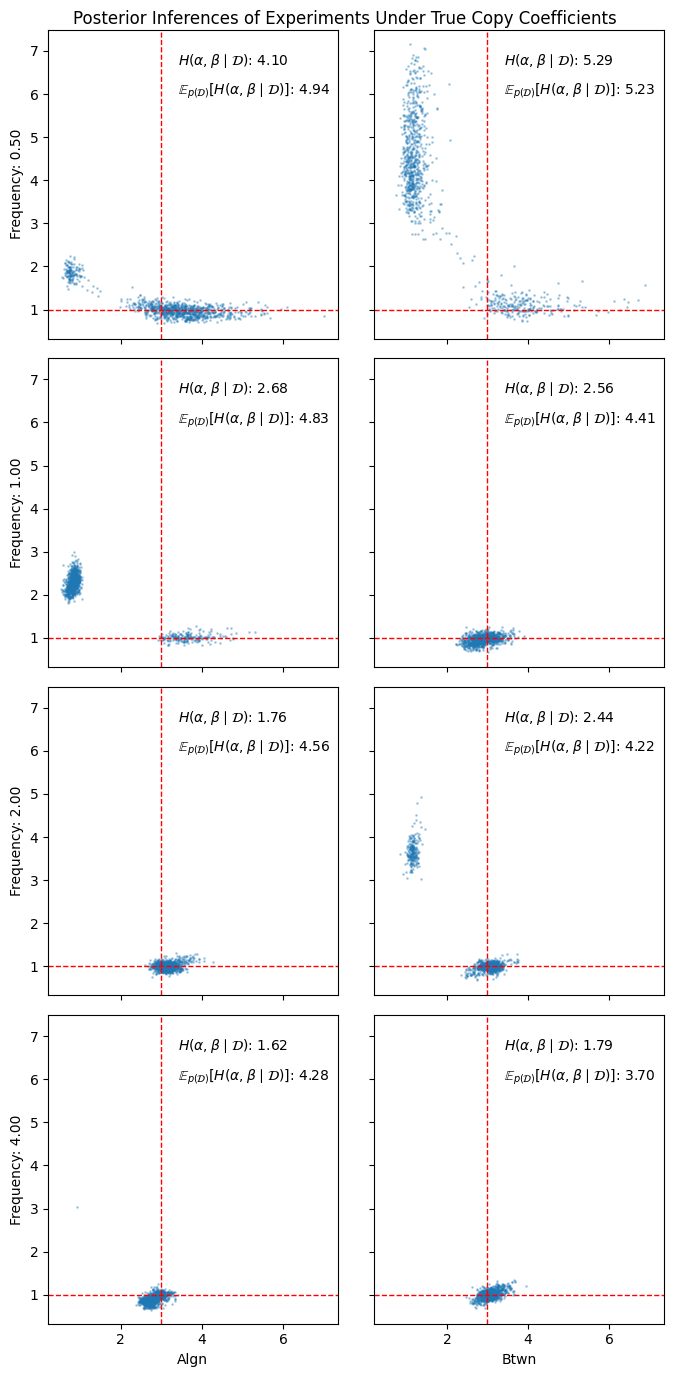

In [116]:
# And visualize the posteriors.
posterior_mesh_array = np.array(flat_grid_posteriors)
# Somewhat annoyingly, numpy introspects the named tuple and converts the entire thing to an array.
gridded_posterior_mesh_array = posterior_mesh_array.reshape(len(grid_frequencies), len(grid_vfish_theta0), 3, 50, 50)
gridded_posterior_mesh_tensor = torch.tensor(gridded_posterior_mesh_array)

fig, axs = plt.subplots(ni, nj, figsize=(7, 14), sharex=True, sharey=True)
for i, j in product(range(ni), range(nj)):
    ax = axs[i][j]
    mesh = PosteriorMesh(*gridded_posterior_mesh_tensor[i, j])
    samples = sample_from_mesh(mesh, 1000)
    s = samples + torch.randn_like(samples) * 0.05
    ax.scatter(s[:, 0].detach(), s[:, 1].detach(), s=1.0, alpha=.3)
    ax.axvline(GET_TRUE_COPY_COEFS()[0].item(), color='red', linestyle='--', linewidth=1.0, alpha=1.0)
    ax.axhline(GET_TRUE_COPY_COEFS()[1].item(), color='red', linestyle='--', linewidth=1.0, alpha=1.0)
    
    entropy = r"$H(\alpha, \beta \mid \mathcal{D})$"
    exp_entropy = r"$\mathbb{E}_{p(\mathcal{D})}[H(\alpha, \beta \mid \mathcal{D})]$"

    ax.text(0.45, 0.9, f"{entropy}: {entropy_from_mesh(mesh):.2f}", horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.45, 0.8, f"{exp_entropy}: {entropies[i * nj + j].mean().item():.2f}", horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes)

label_axes(axs, grid_frequencies, grid_vfish_theta0)
plt.suptitle("Posterior Inferences of Experiments Under True Copy Coefficients")
plt.tight_layout()

##### Expected Entropy Recovers Effective Experiment

From this, we see that our expected entropy measure would have indeed selected a high quality experiment! One with relatively high frequency oscillations and a misaligned starting point. Importantly, the true copy coefficients might be better served by a different experiment than the one identified as the best by the expected entropy. This is unsurprising, as the expected entropy is an average over the space of competing hypotheses, and not a measure of the quality of the experiment for a specific hypothesis.

### Experiments can Be Combined!
Now, in this particular setting, a single virtual fish experiment is sufficient to identify a single mode in our hypothesis space (the space of the two copy coefficients). Sometimes, however, it can be advantageous — or even necessary — to *combine* experiments in order to identify the true hypothesis. To illustrate this point, we'll take two bad experiments from above and combine them to find that together, they result in inferences of much higher quality.

For this illustration, we'll just look at posteriors under the true copy coefficients.

In [107]:
# We'll just re-use this bad experiment!
bad_experimental_context_1 = virtual_fish_A
# And then we'll take our worst experiment from the grid search.
bad_experimental_context_2 = flat_grid_vfish_contexts[1]

In [108]:
# And let's review what their individual posteriors looked like.
bad_experimental_context_posterior_mesh_1 = likelihood_mesh_31_A_noise
bad_experimental_context_posterior_mesh_2 = gridded_posterior_mesh_tensor[0, 1]

In [109]:
# And recover the observations that resulted in those posteriors.
bad_experiment_1_polarizations = pol31_A_noise
bad_experiment_1_trajectory = pol31_A_traj
bad_experiment_2_polarizations = flat_grid_polarizations[1]
bad_experiment_2_trajectory = flat_grid_trajectories[1]

Text(0.5, 1.0, 'Inferences After Bad Experiment 2')

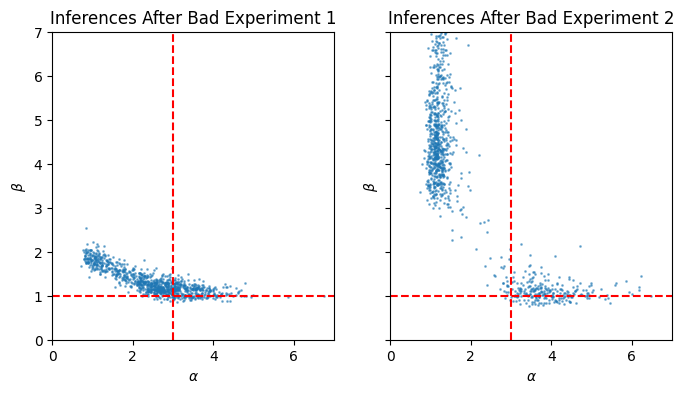

In [110]:
# Plot these side-by-side.
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
plot_posterior(axs[0], bad_experimental_context_posterior_mesh_1)
plot_copy_coef_lines(axs[0])
axs[0].set_title("Inferences After Bad Experiment 1")
plot_posterior(axs[1], PosteriorMesh(*bad_experimental_context_posterior_mesh_2))
plot_copy_coef_lines(axs[1])
axs[1].set_title("Inferences After Bad Experiment 2")

##### Experimental "Meta-Model"
To assist us here, we'll define a "meta-model" that simulates both experiments with a shared set of copy coefficients.

In [111]:
def experimental_meta_model(experimental_contexts: Tuple = (), num_fish: int = 2, ):
    
    copy_coefs = copy_coefficient_prior(num_fish)
    fixed_initial_state = dict(
        thetas=torch.linspace(0., torch.pi, num_fish)
    )
    
    observed_polarizations = []
    trajectories = []
    
    for i, experimental_context in enumerate(experimental_contexts):
        # This "scope" helps differentiate sample sites in the two experimental models, otherwise we'd end up with
        #  multiple sites named "polarization" in the meta-model. `scope` prefixes these sites however, so we end up
        #  sites named "experiment0/polarization" and "experiment1/polarization", for example.
        with scope(prefix=f"experiment{i}"):
            traj, obs_pol = macroscopic_experiment_model(
                num_fish=num_fish,
                macroscopic_noise=HIGH_NOISE,
                experimental_context=experimental_context,
                copy_coefs=copy_coefs,
                initial_state=fixed_initial_state
            )
        trajectories.append(traj)
        observed_polarizations.append(obs_pol)
    
    return trajectories, observed_polarizations

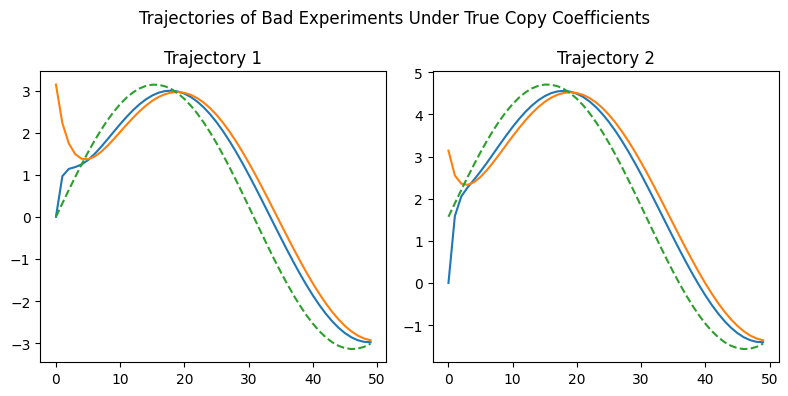

In [112]:
# And we'll visualize these again.
_, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_single_trajectory(axs[0], bad_experiment_1_trajectory)
plot_single_trajectory(axs[1], bad_experiment_2_trajectory)
axs[0].set_title("Trajectory 1")
axs[1].set_title("Trajectory 2")
plt.suptitle("Trajectories of Bad Experiments Under True Copy Coefficients")
plt.tight_layout()

In [113]:
# And we can now run inference on the joint meta-model.
mesh_both = likelihood_mesh_2fish(
    condition(
        partial(experimental_meta_model, experimental_contexts=(bad_experimental_context_1, bad_experimental_context_2)),
        data={
            "experiment0/polarization": bad_experiment_1_polarizations,
            "experiment1/polarization": bad_experiment_2_polarizations
        }
    ),
    n=50
)

Progress 2500/2500


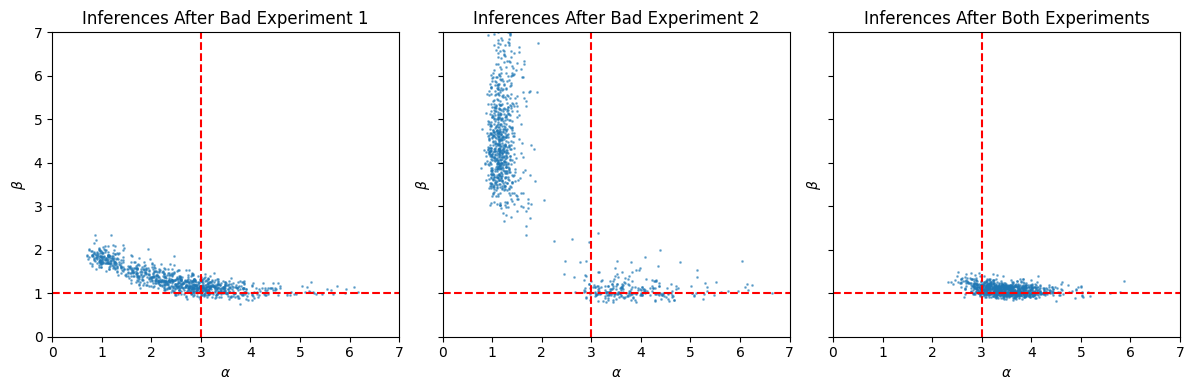

In [114]:
# And plot the joint alongside the individual posteriors.
_, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

plot_posterior(axs[0], bad_experimental_context_posterior_mesh_1)
plot_copy_coef_lines(axs[0])
axs[0].set_title("Inferences After Bad Experiment 1")

plot_posterior(axs[1], PosteriorMesh(*bad_experimental_context_posterior_mesh_2))
plot_copy_coef_lines(axs[1])
axs[1].set_title("Inferences After Bad Experiment 2")

plot_posterior(axs[2], mesh_both)
plot_copy_coef_lines(axs[2])
axs[2].set_title("Inferences After Both Experiments")

plt.tight_layout()
pass

##### Posterior Under Meta-Model with Both Experiments

Indeed, by combining these two poor experiments, we can infer a much tighter posterior than would have otherwise been possible.

Roughly speaking, their joint posterior shows a sort of *intersection* between the two posteriors. In more troublesome cases than this one — where neither of the two experiments can fully identify the truth even under minimal noise — combining them can result in a sort of cross-referencing that does identify the correct hypothesis.

Importantly, in an experimental design setting, these experimental "meta-models" can be evaluated with expected entropy too, just like a standard model. This helps identify "batches" of experiments that, when taken together, will most efficiently identify the truth. On a similar note, these experiments can be performed sequentially in an intuitive Bayesian-style update. Instead of computing the expected entropy with respect to prior uncertainty, we can compute it with respect to posterior uncertainty from a previous experiment. This constitutes a "greedy" sequential experimental design, in which the next experiment is chosen to minimize the expected entropy of the posterior after the next experiment.   

# Conclusion

In this notebook, we explored a toy fish schooling problem to explore the benefits of Bayesian experimental design in non-identified settings. As long as the scientist is able to model what will happen under a space of experiments and hypotheses, this pipeline can be used to identify efficient experimental protocols to differentiate between competing hypotheses. In practice, of course, this information can be further combined with the cost of running an experiment, resulting in a holistic approach to efficiently answering scientific questions.